In [1]:
import tensorflow as tf
from tensorflow.keras import models
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
import os

In [2]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import numpy as np

from DataAugmentation import preprocessing,preprocessing_val,augmentations

In [3]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [5]:
model_trainable = False #Decide si es entrenable toda la red o no
model_training = False # Decide si re entrenar el BN o no
model_epochs = 20
base_learning_rate =0.001

num_classes = 101
final_activation = "softmax"

In [6]:
model_backbone = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                      weights='imagenet',
                                                      #input_shape=(224,224,3),
                                                      pooling="avg")

model_backbone.trainable = model_trainable


inputs = tf.keras.Input(shape=(224, 224, 3))
x = model_backbone(inputs, training=model_training)
x = tf.keras.layers.Dropout(0.2)(x) 
output = tf.keras.layers.Dense(num_classes,activation=final_activation)(x)
model = tf.keras.Model(inputs, output)

In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
train,val = tfds.load('food101', split=['train', 'validation'],data_dir="/tf/FoodClassifier/Training")


#Para efficientnet de la versión de TF.KERAS la nroamlización se hace internamente
train = train.map(preprocessing)
train = train.map(augmentations,num_parallel_calls=8)
train = train.batch(8)

val = val.map(preprocessing)
val = val.batch(16)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=4, verbose=1, mode='auto',min_delta=0.05)


checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

history = model.fit(train,epochs=model_epochs,validation_data=val,callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/20
9465/9469 [============================>.] - ETA: 0s - loss: 1.9093 - accuracy: 0.5248
Epoch 00001: val_accuracy improved from -inf to 0.66978, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 143s 15ms/step - loss: 1.9093 - accuracy: 0.5248 - val_loss: 1.2278 - val_accuracy: 0.6698
Epoch 2/20
9464/9469 [============================>.] - ETA: 0s - loss: 1.5455 - accuracy: 0.6025
Epoch 00002: val_accuracy improved from 0.66978 to 0.68578, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 141s 15ms/step - loss: 1.5456 - accuracy: 0.6024 - val_loss: 1.1562 - val_accuracy: 0.6858
Epoch 3/20
9465/9469 [============================>.] - ETA: 0s - loss: 1.4735 - accuracy: 0.6209
Epoch 00003: val_accuracy improved from 0.68578 to 0.68935, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 133s 14ms/step - loss: 1.4735 - accuracy: 0.6209 - val_loss: 1.1476 - val_accuracy: 0.6893
Epoch 4/20
9463/

In [11]:
import matplotlib.pyplot as plt

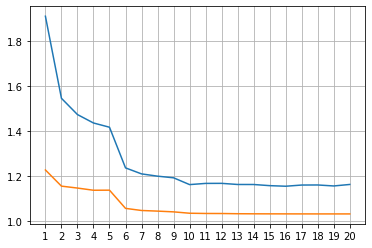

In [12]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = np.arange(1,21,1)

plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.xticks(epochs);
plt.grid()

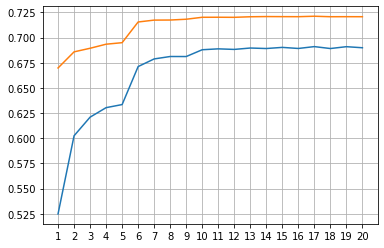

In [13]:
train_loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]

epochs = np.arange(1,21,1)

plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.xticks(epochs);
plt.grid()

### FINE TUNING

In [14]:
# Unfreeze the base model
model_backbone.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

history = model.fit(train,epochs=10,validation_data=val,callbacks=[model_checkpoint_callback])

Epoch 1/10
9469/9469 [==============================] - ETA: 0s - loss: 1.0467 - accuracy: 0.7204
Epoch 00001: val_accuracy improved from -inf to 0.76202, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 430s 45ms/step - loss: 1.0467 - accuracy: 0.7204 - val_loss: 0.8617 - val_accuracy: 0.7620
Epoch 2/10
9468/9469 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.7507
Epoch 00002: val_accuracy improved from 0.76202 to 0.77600, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 431s 46ms/step - loss: 0.9151 - accuracy: 0.7507 - val_loss: 0.8072 - val_accuracy: 0.7760
Epoch 3/10
9468/9469 [============================>.] - ETA: 0s - loss: 0.8274 - accuracy: 0.7739
Epoch 00003: val_accuracy improved from 0.77600 to 0.78257, saving model to training_3/cp.ckpt
9469/9469 [==============================] - 433s 46ms/step - loss: 0.8274 - accuracy: 0.7739 - val_loss: 0.7804 - val_accuracy: 0.7826
Epoch 4/10
9469/

## Save best model to .pb file

In [16]:
model.load_weights(checkpoint_path)
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
